
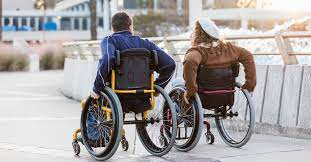

# <font color='darkorange'>Neural network model for image data</font>

## <font color='darkorange'>Question of interest</font>

<font size = 6 >
Is it possible for my machine learning model to make predictions about three different type of situation from an image dataset? Which type of model would be more proficient in achieving accurate predictions among the 3 distinct label classes?
</font>


<font size = 4 >
This dataset is an image dataset with labeled folders, which makes it a supervised machine learning task.
I uploaded myself in kaggle based on two different dataset then labeled and restructred them.
I plan to use different  types of models:

I used the functional approach to model building in my first model and two different pre-trained models namely EfficientNetB0 and MobileNetV2.

Although dense layers are good for predicting numerical weights patterns, I believe that CNNs/convnet, which use weighted filters, are better at understanding details in the images and spatial complexity. This should help us make more accurate predictions about the images.
</font>

In [1]:
# @title necessary libraries
#Import necessary libraries
import pandas as pd
import numpy as np
import os, warnings
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Dropout , BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing


import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
warnings.filterwarnings("ignore")

## <font color='darkorange'>Data Story</font>


The implementation of automatic doors for wheelchair users not only enhances hospital entry accessibility, ensuring patient safety and preventing accidents, but also ensures regulatory compliance by adhering to accessibility standards and avoiding legal issues. This initiative contributes to an enhanced patient experience by providing a convenient and welcoming entry, thereby boosting overall satisfaction. Moreover, the streamlined entry process leads to efficient care delivery by minimizing delays and frustrations among healthcare professionals, positively impacting the hospital's workflow. Beyond functional benefits, this project serves as a testament to the hospital's commitment to inclusivity, cultivating a positive reputation and expanding its patient base. Importantly, the investment in accessibility bears the potential for financial growth through increased patient retention, heightened revenue, and a favorable long-term return on investment.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Small dataset from Housing and Accessibility : https://www.kaggle.com/datasets/peacehegemony/housing-and-accessibility

In [3]:
encoding = 'latin1'  # Example encoding

# Read the CSV file using the specified encoding
df_viz = pd.read_csv('/content/drive/MyDrive/housing-wheelchairs-DFE.csv', encoding=encoding)

In [4]:
df_viz.isna().sum() / len(df_viz)

house_types                   0.451923
house_types:confidence        0.394231
residential_yes               0.000000
residential_yes:confidence    0.000000
sidewalk_ok                   0.451923
sidewalk_ok:confidence        0.394231
aadress                       0.000000
house_types_gold              0.509615
house_types_gold_reason       0.519231
residential_yes_gold          0.009615
sidewalk_ok_gold              0.625000
sidewalk_ok_gold_reason       0.576923
dtype: float64

From a very small dataset, up to 22% of the houses do not even have a sidewalk
All the no answers are followed by : The sidewalk/pedestrian path is not safe for wheelchairs .
it is not continuous or not wide enough or there seems to be other issues with the sidewalk

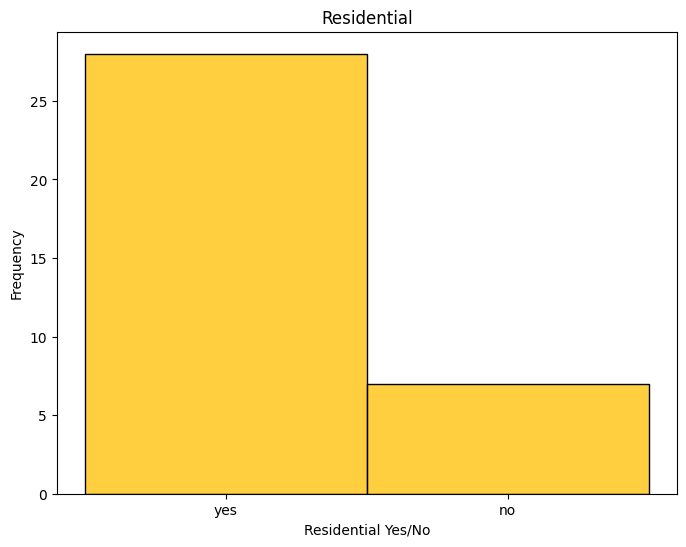

In [5]:
# @title wheelchair users reviews
df_viz_1 = df_viz['sidewalk_ok_gold'][(df_viz['sidewalk_ok_gold'] == 'yes') | (df_viz['sidewalk_ok_gold'] == 'no')]


# Color customization
default_palette = sns.color_palette()
custom_palette = default_palette.copy()
custom_palette[1] = '#ffbf00'  # Light orange color (you can replace this with your desired color)
sns.set_palette(custom_palette)

# Create and display the histogram
plt.figure(figsize=(8, 6))
sns.histplot(data=df_viz_1, color=custom_palette[1], kde=False)
plt.title('Residential')
plt.xlabel('Residential Yes/No')
plt.ylabel('Frequency')
plt.gca().set_facecolor('none')  # Set transparent background

plt.show()

In [6]:
# @title Datasets Upload  (needs a .json file from Kaggle API)
#######
#After running this block of code you will have to upload the json file you get from Kaggle that contains the API token
#######
#load data
#install Kaggle
! pip install -q kaggle
from google.colab import files
# choose the kaggle.json file that you downloaded
files.upload()
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
# change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json
#download the kaggle dataset after uploading the Kagggle JSON token
!kaggle datasets download -d hichamdioury4ds/humanvsnohumanvswheelchair


Saving kaggle.json to kaggle.json
 88% 66.0M/74.9M [00:01<00:00, 68.8MB/s]
100% 74.9M/74.9M [00:01<00:00, 73.4MB/s]


In [7]:
# @title unzip
#%%capture

!unzip humanvsnohumanvswheelchair.zip -d dataset_folder

Archive:  humanvsnohumanvswheelchair.zip
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/0.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/10.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/103.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/106.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/107.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/108.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/118.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/125.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/128.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/148.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/155.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelChair/test/Human/16.png  
  inflating: dataset_folder/HumanVsNoHumanVsWheelCh

## <font color='darkorange'>Data wrangling / preprocessing</font>

Get your data ready to be inputed into your NN model. Don't forget to split your data so that you'll have a testing dataset at the end. (Marks: 10)

In [8]:
# @title src dir
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib, os

#Set the path to the images
new_base_dir = pathlib.Path("/content/dataset_folder/HumanVsNoHumanVsWheelChair")

Each file has around 230 images for each animal type

In [9]:
# @title Training DataSet
#Training data
train_dataset = image_dataset_from_directory(
            new_base_dir / "train",
            image_size=(224, 224),
            batch_size=35)

Found 1004 files belonging to 3 classes.


In [10]:
# @title Validation DataSet
#validation data
validation_dataset = image_dataset_from_directory(
            new_base_dir / "validation",
            image_size=(224, 224),
            batch_size=35)


Found 335 files belonging to 3 classes.


In [ ]:
# @title Testing DataSet
#test data
test_dataset = image_dataset_from_directory(
           new_base_dir / "test",
           image_size=(224, 224),
           batch_size=1)

Found 337 files belonging to 3 classes.


-Separating my training datasets in 35 image batches for my models

In [11]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (35, 224, 224, 3)
labels batch shape: (35,)


We have 3 different type of situations :

In [12]:
# @title Numbers of classes
def convert(mylist):
  return [item.lower() for item in mylist]

class_names = train_dataset.class_names
print(convert(class_names))

['human', 'nohuman', 'wheelchair']


we have multipe images for each classes with a good quality and 3 depth of colors RGB

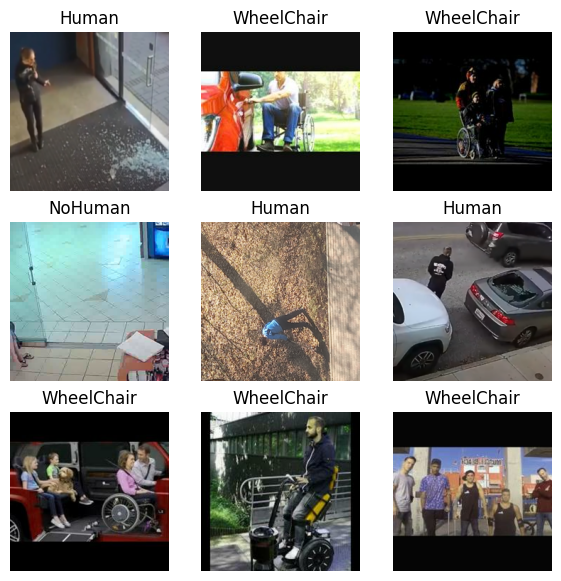

In [14]:
# @title different classes images
plt.figure(figsize = (7,7))
for image, label_folder in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image[i].numpy().astype('uint'))
        plt.title(class_names[label_folder[i]])
        plt.axis('off')

Our images are 224 * 224

In [15]:
# @title Image size
from PIL import Image

# Open an image
image_path = "/content/dataset_folder/HumanVsNoHumanVsWheelChair/train/WheelChair/100_png.rf.5eed53ba06ea9a336243ba666c65f01d.jpg"
image = Image.open(image_path)
width, height = image.size
print("Image width:", width)
print("Image height:", height)


Image width: 224
Image height: 224


## <font color='darkorange'>Model building</font>

### <font color='darkorange'>CNN and dense layer Model</font>

In [16]:
data_augmentation = keras.Sequential(
            [
               layers.RandomFlip("horizontal"),
               layers.RandomRotation(0.1),
               layers.RandomZoom(0.2),
] )

In [27]:

#define all the layers of the model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) #added data augmentation
x = layers.Rescaling(1./256)(x)

res = x
x = layers.SeparableConv2D(filters=32, kernel_size=3, activation="relu", padding = 'same', use_bias=False) (x)
x = BatchNormalization()(x)
x= layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding = 'same')(x)
res = layers.SeparableConv2D(32, 1, strides = 2)(res)
x = layers.add([x,res])


res = x
x = layers.SeparableConv2D(filters=64, kernel_size=3, activation="relu", padding = 'same', use_bias=False) (x)
x = BatchNormalization()(x)
x= layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2, padding = 'same')(x)
res = layers.SeparableConv2D(64, 1, strides = 2)(res)
x = layers.add([x,res])


x = layers.SeparableConv2D(filters=128, kernel_size=3, activation="relu", padding = 'same') (x)
x = layers.MaxPooling2D(pool_size=2, padding = 'same')(x)

x = layers.SeparableConv2D(filters=512, kernel_size=3, activation="relu", padding = 'same') (x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

#build the model
model = keras.Model(inputs=inputs, outputs=outputs)

#2. Compile the model
model.compile(
             #optimizer="rmsprop",
             optimizer="adam",
             loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="cnn_model.keras",
    save_best_only=True,
    monitor="val_accuracy"),

    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5)
  ]

Let's look at our model.

We employ a dual neural network architecture, operating in parallel, with the inclusion of residual connections. These residual connections play a vital role in optimizing the backpropagation process, facilitating enhanced learning and convergence within our convolutional neural network (CNN) model.

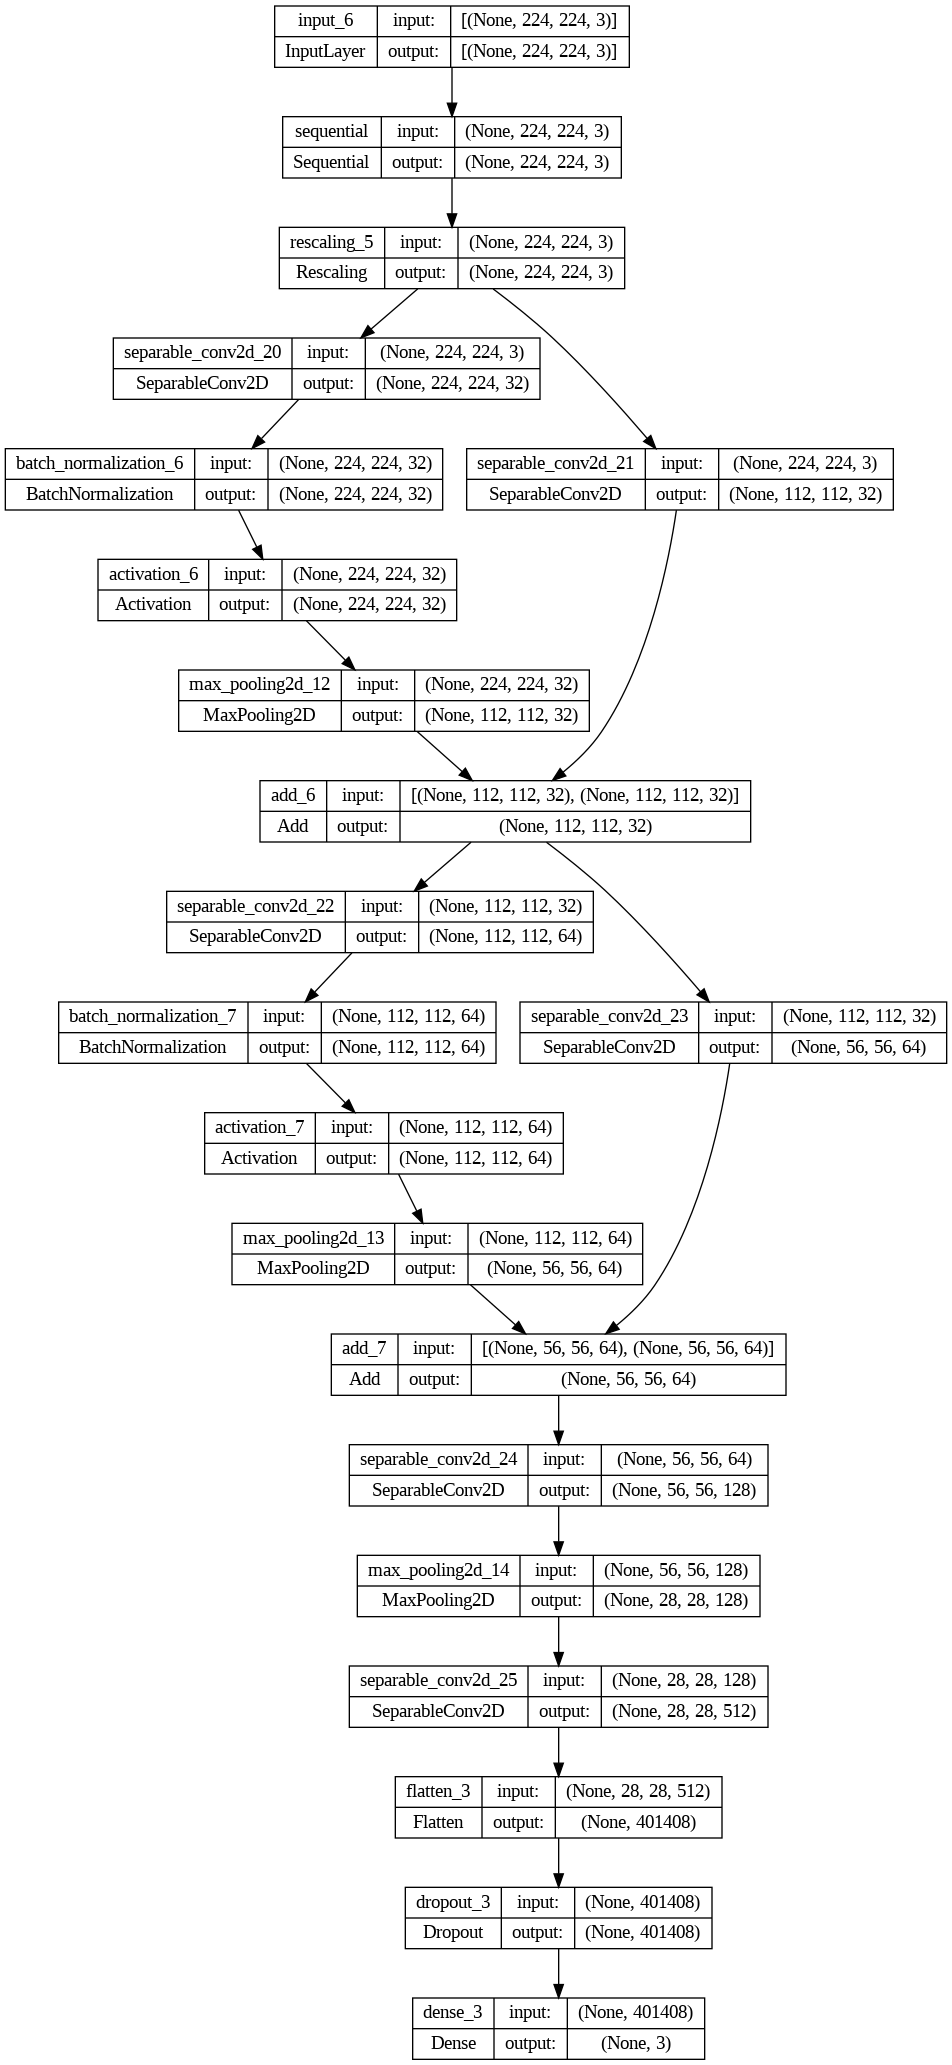

In [29]:
plot_model(model, show_shapes=True)

In [30]:
history = model.fit(train_dataset,
                    epochs=50,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/50
29/29 [==============================] - 10s 132ms/step - loss: 0.7050 - accuracy: 0.6723 - val_loss: 2.5517 - val_accuracy: 0.4537
Epoch 2/50
29/29 [==============================] - 4s 131ms/step - loss: 0.5277 - accuracy: 0.7291 - val_loss: 1.2635 - val_accuracy: 0.4537
Epoch 3/50
29/29 [==============================] - 5s 128ms/step - loss: 0.4841 - accuracy: 0.7689 - val_loss: 1.8381 - val_accuracy: 0.4537
Epoch 4/50
29/29 [==============================] - 4s 116ms/step - loss: 0.4302 - accuracy: 0.7888 - val_loss: 1.1239 - val_accuracy: 0.4478
Epoch 5/50
29/29 [==============================] - 4s 139ms/step - loss: 0.4340 - accuracy: 0.7988 - val_loss: 1.8186 - val_accuracy: 0.4537
Epoch 6/50
29/29 [==============================] - 4s 119ms/step - loss: 0.4377 - accuracy: 0.7839 - val_loss: 0.7022 - val_accuracy: 0.6866
Epoch 7/50
29/29 [==============================] - 4s 138ms/step - loss: 0.3665 - accuracy: 0.8327 - val_loss: 0.7010 - val_accuracy: 0.6687
Epoch

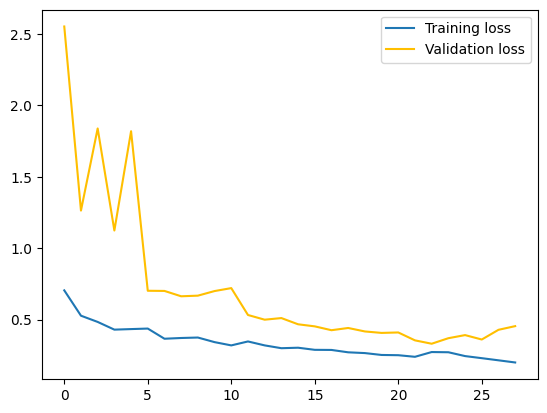

In [31]:
#make the training and validation accuracy plot
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()

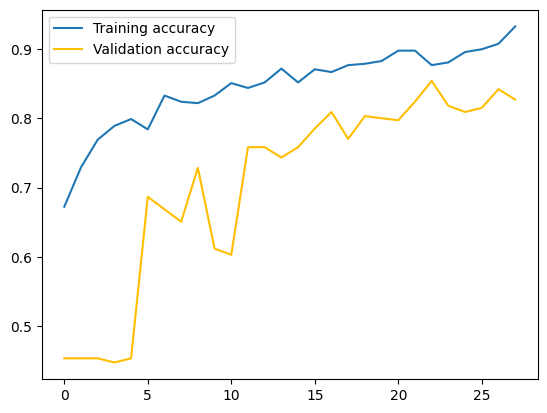

In [32]:
#make the training and validation accuracy plot
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()

In [ ]:
round( max(history.history["val_accuracy"]), 3)

0.66

### <font color='darkorange'>Pre-trained Model building EfficientNetB0</font>

In [33]:
conv_base  = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='max')
# Freezing the layers of a pretrained neural network
for i, layer in enumerate(conv_base.layers):
    conv_base.layers[i].trainable = False

16705208/16705208 [==============================] - 0s 0us/step


We are employing data augmentation to intentionally amplify the diversity and size of the training dataset.

In [34]:
data_augmentation = keras.Sequential(
            [
               layers.RandomFlip("horizontal"),
               layers.RandomRotation(0.1),
               layers.RandomZoom(0.2),
] )

In [40]:
from tensorflow.keras.optimizers import RMSprop
#define the model

inputs = keras.Input(shape=(224, 224, 3), name='inputLayer')
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
pretrain_out = conv_base(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = BatchNormalization()(x)
x = layers.Dense(10)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = keras.Model(inputs=inputs, outputs=outputs)


learning_rate = 0.0001
optimizer = RMSprop(learning_rate=learning_rate)

#compile the model
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [41]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#set the early stopping and model saving
callbacks = [



    EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),

]


In [42]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=callbacks
)
model.save_weights('/content/feature_extraction_with_EfficientNetB0.keras')

Epoch 1/5
29/29 [==============================] - 13s 206ms/step - loss: 1.4733 - accuracy: 0.5558 - val_loss: 1.8251 - val_accuracy: 0.7582
Epoch 2/5
29/29 [==============================] - 4s 109ms/step - loss: 0.7412 - accuracy: 0.7968 - val_loss: 0.6990 - val_accuracy: 0.8149
Epoch 3/5
29/29 [==============================] - 4s 112ms/step - loss: 0.4760 - accuracy: 0.8775 - val_loss: 0.4945 - val_accuracy: 0.8627
Epoch 4/5
29/29 [==============================] - 5s 146ms/step - loss: 0.3852 - accuracy: 0.8845 - val_loss: 0.3688 - val_accuracy: 0.8746
Epoch 5/5
29/29 [==============================] - 4s 110ms/step - loss: 0.2956 - accuracy: 0.9153 - val_loss: 0.3213 - val_accuracy: 0.8896


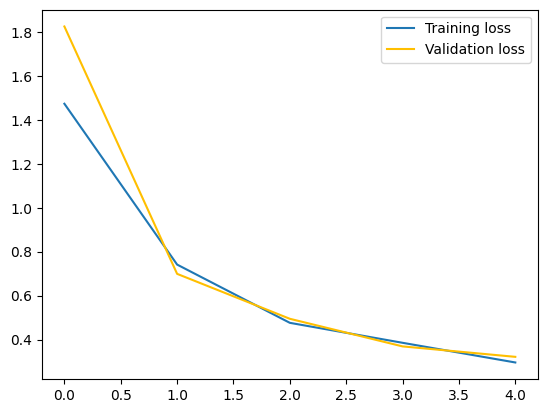

In [43]:
#make the training and validation accuracy plot
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()

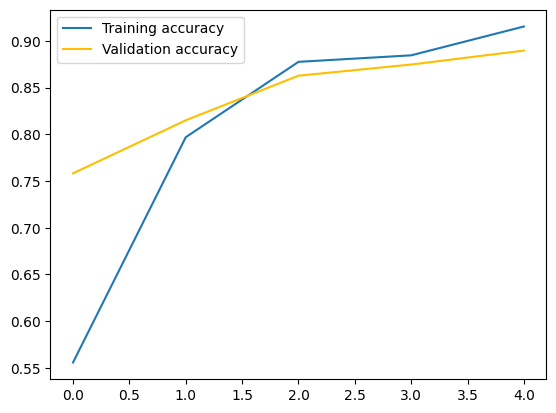

In [44]:
#make the training and validation accuracy plot
plt.plot(history.history['accuracy'], label="Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()

In [45]:
#say where to find the test data
new_base_dir = "/content/dataset_folder/HumanVsNoHumanVsWheelChair/test"

#test data
test_dataset = image_dataset_from_directory(
            new_base_dir,
            image_size=(224, 224),
            batch_size=40)

Found 337 files belonging to 3 classes.


## <font color='darkorange'>Model testing Second  and Best Model</font>

In [46]:
results = model.evaluate(test_dataset, verbose=0)
print(f"Test Loss: {results[0]:.5f}")
print(f"Test Accuracy: {results[1] * 100:.2f}%")

Test Loss: 0.39983
Test Accuracy: 89.91%


In [47]:
class_names = train_dataset.class_names

Interestingly when it's sees a thin shape of  any kind , it labels it as a Human vs a circular shape like a wheel it labels it as wheelchair

1/1 [==============================] - 0s 27ms/step


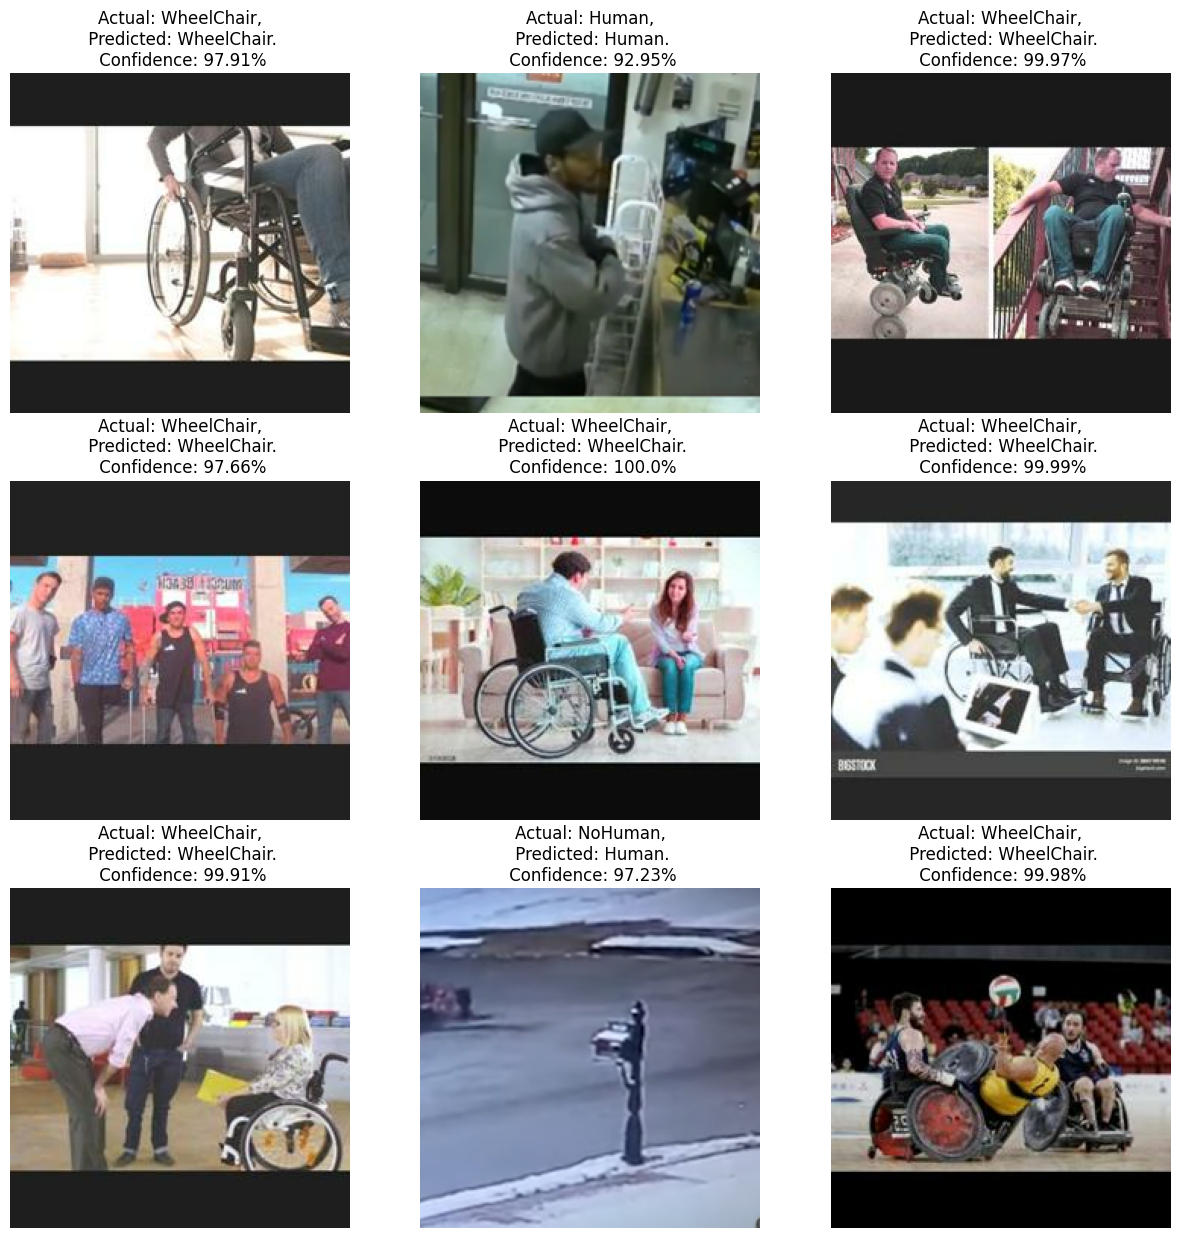

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

The chosen model architecture includes a data augmentation layer for input preprocessing, followed by an EfficientNet convolutional base, which serves as a feature extractor.

The decision to incorporate a Dense layer with 256 units after the convolutional base aims to introduce intermediate complexity and facilitate effective feature mapping.

Batch normalization is applied, It works by normalizing the activations of each layer within a mini-batch

Another Dense layer with 10 units is included to match the number of classes, and an activation layer using softmax activation ensures suitable class probabilities for multiclass classification.

These selections were made to balance model complexity and capacity, leverage the EfficientNet's pretrained features, and achieve optimal classification performance.

## <font color='darkorange'>Pre-trained Model building MobilNetV2</font>

In [49]:
input_shape = (224, 224, 3)
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [56]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layers.Dense(256)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)

#build the model
model = keras.Model(inputs=inputs, outputs=outputs)

#2. Compile the model
model.compile(
             #optimizer="rmsprop",
             optimizer="adam",
             loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [57]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="MobileNet.keras",
    save_best_only=True,
    monitor="val_accuracy"),

    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5)
  ]

In [58]:
history = model.fit(train_dataset,
                    epochs=50,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/50
29/29 [==============================] - 10s 184ms/step - loss: 0.7425 - accuracy: 0.7510 - val_loss: 0.6801 - val_accuracy: 0.7433
Epoch 2/50
29/29 [==============================] - 3s 96ms/step - loss: 0.4639 - accuracy: 0.8207 - val_loss: 0.4702 - val_accuracy: 0.8030
Epoch 3/50
29/29 [==============================] - 3s 95ms/step - loss: 0.4058 - accuracy: 0.8376 - val_loss: 0.5017 - val_accuracy: 0.8060
Epoch 4/50
29/29 [==============================] - 3s 94ms/step - loss: 0.3590 - accuracy: 0.8556 - val_loss: 0.4394 - val_accuracy: 0.8119
Epoch 5/50
29/29 [==============================] - 5s 145ms/step - loss: 0.3042 - accuracy: 0.8745 - val_loss: 0.3976 - val_accuracy: 0.8358
Epoch 6/50
29/29 [==============================] - 3s 94ms/step - loss: 0.2658 - accuracy: 0.8805 - val_loss: 0.3613 - val_accuracy: 0.8418
Epoch 7/50
29/29 [==============================] - 3s 84ms/step - loss: 0.2470 - accuracy: 0.8984 - val_loss: 0.4479 - val_accuracy: 0.8269
Epoch 8/50

In [59]:
#say where to find the test data
new_base_dir = "/content/dataset_folder/HumanVsNoHumanVsWheelChair/test"

#test data
test_dataset = image_dataset_from_directory(
            new_base_dir,
            image_size=(224, 224),
            batch_size=40)

Found 337 files belonging to 3 classes.



While MobileNetV2 is a notable pre-trained model, EfficientNetB0 exhibited superior performance.

In [60]:
model.evaluate(test_dataset)

9/9 [==============================] - 2s 93ms/step - loss: 0.4795 - accuracy: 0.8546


[0.47948363423347473, 0.8545994162559509]

## <font color='darkorange'>Model testing first Model CNN </font>

My CNN have an acceptable lost and accuracy

In [61]:
model = keras.models.load_model("/content/cnn_model.keras")

model.evaluate(test_dataset)

9/9 [==============================] - 1s 58ms/step - loss: 0.3414 - accuracy: 0.8457


[0.3413718342781067, 0.8456973433494568]

In [62]:
class_names = train_dataset.class_names

1/1 [==============================] - 0s 23ms/step


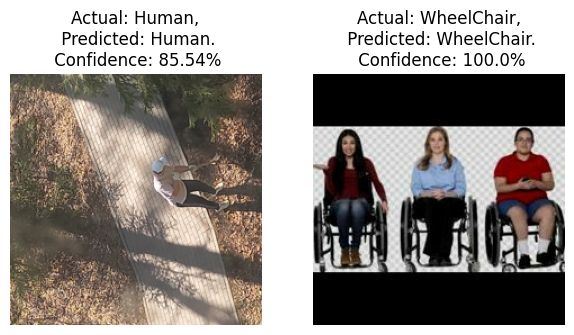

In [63]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(10):
    for i in range(2):
        ax = plt.subplot(4, 4, i + 2)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

## <font color='darkorange'>Discussion</font>
The convolutional approach generally outperforms the dense model in image tasks due to its ability to capture image patterns.

Convolutional models excel in image-related tasks by extracting spatial features, resulting in higher accuracy. Dense models are better suited for tabular data and may struggle with image complexities

The pre-trained models, especially when using Imagenet data, tends to be superior due to its well-trained CNN layers and weight initialization.

My first model(CNN) had a val accuracy of 0.84
My third model had a val accuracy of 0.85
My second model with EfficientNEtB0 outperformed them all with a 0.89 almost 90% in a model that have to choose between 3 possible choices.